In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble

In [2]:
def safe_drop(df, cols):
    try:
        if type(cols)==str:
            cols = [cols]
        fld_drop = df.columns[df.columns.isin(cols)]
        results = df.copy()
        results.drop(fld_drop, inplace=True, axis=1)
    except Exception as e:
        print(e)
        results=df
    finally:
        return(results)

# How to play around with improving this
1. Increase iterations
1. Decrease iterations
1. Change loss function from deviance to exponential
1. Increase tree depth
1. Drop...Germany? The country that only has 27 entries.

In [6]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv"))

In [7]:
md = pd.DataFrame({'field': df.columns,
                   'd_type': df.dtypes,
                   'nulls': df.apply(lambda x: x.isna().sum())
                  })

In [27]:
results_predictions = pd.DataFrame(columns=['actual', 'prediction', 'model_no'])
result_summ = pd.DataFrame(columns=['acc', 'type1', 'type2', 'time', 'model_no'])
cnt = 1

# Model 1: Baseline shown in example

In [16]:
X = df.dropna()
y = X.partner - 1

X = safe_drop(X, ['idno', 'partner'])
X = pd.get_dummies(X)

In [17]:
from sklearn.model_selection import cross_val_predict as cvp
from time import perf_counter

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
start = perf_counter()
clf = ensemble.GradientBoostingClassifier(**params)
end = perf_counter()

predictions = cvp(clf, X, y, cv=3)

In [18]:
try:
    results_predictions.drop(results_predictions.loc[results_predictions.model_no==1].index, inplace=True)
except Exception as e:
    print(e)
results_predictions = pd.concat([results_predictions, pd.DataFrame({'actual': y, 'prediction': predictions, 'model_no': cnt})])

In [21]:
def compute_acc(actual, predict):
    tab = pd.crosstab(actual, predict, margins=True)
    results = {'acc': (tab.loc[0, 0] + tab.loc[1, 1])/tab.loc['All', 'All'],
               'type1': tab.loc[0, 1]/tab.loc['All', 'All'],
               'type2': tab.loc[1,0]/tab.loc['All', 'All']}
    return(results)

In [34]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt



('acc', 'type1', 'type2', 'time', 'model_no')

In [47]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0


In [49]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0} seconds'.format(summ['time']))

Overall accuracy: 0.686
Type I error: 0.120
Type II error: 0.195
Time elapsed: 5.497400002241193e-05 seconds


Why are my accuracy results different from the results in the guided example?

## Feature importance

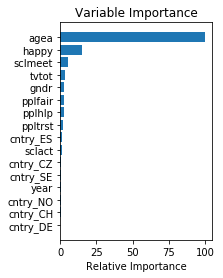

In [50]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

clf.fit(X_train, y_train)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Model 2: Dropping Germany
Hypothesis: Removing Germany will improve model accuracy. Germany only has 27 records in the final data set and unbalanced datasets can be problemmatic.

In [51]:
cnt += 1

In [52]:
X = df.dropna()
X = X.loc[X.cntry!='DE']
y = X.partner - 1

X = X.drop(['idno', 'partner'], axis=1)
X = pd.get_dummies(X)

In [54]:
from sklearn.model_selection import cross_val_predict as cvp

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
start = perf_counter()
clf = ensemble.GradientBoostingClassifier(**params)
end = perf_counter()

predictions = cvp(clf, X, y, cv=3)

In [55]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [65]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0


In [58]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.682
Type I error: 0.120
Type II error: 0.198
Time elapsed: 0.0 seconds


It looks like eliminating those rows did decreased performance, albeit very slightly.

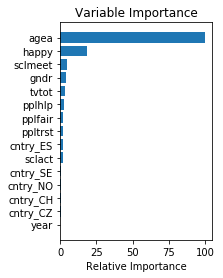

In [59]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

clf.fit(X_train, y_train)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Increasing the number of iterations

In [60]:
cnt += 1

In [61]:
X = df.dropna()
y = X.partner - 1

X = X.drop(['idno', 'partner'], axis=1)
X = pd.get_dummies(X)

In [62]:
from time import perf_counter

from sklearn.model_selection import cross_val_predict as cvp

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()
print('Elapsed time: {0} seconds'.format(end-start))

Elapsed time: 8.152791321999985 seconds


In [63]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [67]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0


In [68]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.679
Type I error: 0.123
Type II error: 0.198
Time elapsed: 8.2 seconds


Interesting. Increasing the iteractions actually reduced fit. Would that be due to overfitting? What happens if I decrease the number of iterations?

# Model 4: Decreasing the number of iterations
Hypothesis: decreasing the number of iterations will improve performance by reducing overfitting.

In [69]:
cnt += 1

In [70]:
X = df.dropna()
y = X.partner - 1

X = X.drop(['idno', 'partner'], axis=1)
X = pd.get_dummies(X)

In [71]:
from time import perf_counter

from sklearn.model_selection import cross_val_predict as cvp

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()
# print('Elapsed time: {0} seconds'.format(end-start))

In [72]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [73]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0


In [74]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.687
Type I error: 0.118
Type II error: 0.196
Time elapsed: 2.0 seconds


My model does slightly better, though not by very much. I think it's time to swap out the loss function and see what happens.

# Model 5: Switching the loss function from deviance to exponential
I'm keeping 250 iterations since that's given me my best accuracy yet, but I'm swithcing the loss function from deviance to exponential.

In [75]:
cnt += 1

In [76]:
X = df.dropna()
y = X.partner - 1

X = X.drop(['idno', 'partner'], axis=1)
X = pd.get_dummies(X)

In [77]:
from time import perf_counter

from sklearn.model_selection import cross_val_predict as cvp

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 2,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()
print('Elapsed time: {0} seconds'.format(end-start))

Elapsed time: 1.9345432060001713 seconds


In [78]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [79]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0
4,0.681110,0.116976,0.201915,1.934543,5.0


In [80]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.681
Type I error: 0.117
Type II error: 0.202
Time elapsed: 1.9 seconds


And my results there are worse than baseline and the previous model.

# Model 6: Feature Engineering
My former experiments suggest that there isn't a lot of performance gain to be had from tweaking different hyperparameters, which suggests that the features themselves could stand to be optimized. Moreover, when I looked at feature importance the same three features stood out as important: agea, happy, and sclmeet (which I think has to do with how often people are social). For this experiment I will try the following:
- Drop country, which does not appear to be adding anything to the model and may be adding noise;
- Combine via PCA ppltrst, pplfair, and pplhlp which are highly correlated; and
- Create higher degree variables from the continuous variables.

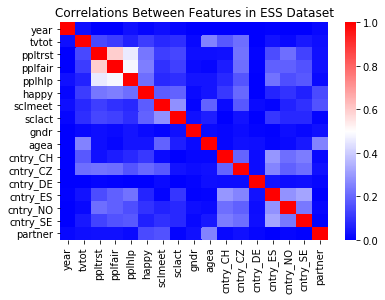

In [81]:
z = X.copy()
z['partner'] = y
sns.heatmap(z.corr().abs(), cmap = 'bwr')
plt.title('Correlations Between Features in ESS Dataset')
plt.show()
del z

## Dropping Country and year
If we examine the feature importance plots above we see that county and year are of relatively little importance. Dropping these variables should improve performance by decreasing noise.

In [82]:
cnt += 1

In [83]:
X = safe_drop(df, ['idno', 'cntry', 'year'])
X = X.dropna()
y = X.partner - 1
X = safe_drop(X, 'partner')
X.columns

Index(['tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet', 'sclact',
       'gndr', 'agea'],
      dtype='object')

In [84]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()
print('Elapsed time: {0} seconds'.format(end-start))

Elapsed time: 1.6243057950000548 seconds


In [85]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [86]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0
4,0.681110,0.116976,0.201915,1.934543,5.0
5,0.748251,0.059040,0.192709,1.624306,6.0


In [87]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.748
Type I error: 0.059
Type II error: 0.193
Time elapsed: 1.6 seconds


Whoa...That actually helped a lot.

## Combining correlated features
The only variables that exibit a correlation over 0.3 are "ppltrst", "pplhlp", and "pplfair." I will therefore combine these three variables.

In [88]:
cnt += 1

In [89]:
cor = df.loc[:, ~df.columns.isin(['idno', 'cntry', 'year'])].corr().reset_index()
cor.columns = cor.columns.str.replace('index', 'field_1')
cor = cor.melt(id_vars='field_1', var_name='field_2', value_name='pearson')
cor.loc[(cor.field_1!=cor.field_2) & (cor.field_1>cor.field_2) & (cor.pearson>0.3)].sort_values('pearson', ascending=False)

,field_1,field_2,pearson
21,ppltrst,pplfair,0.592001
23,pplhlp,pplfair,0.480918
31,ppltrst,pplhlp,0.462562


In [90]:
from sklearn.decomposition import PCA as pca

X = safe_drop(df, ['idno', 'cntry', 'year']).dropna()
y = X.partner - 1
X = safe_drop(X, 'partner')

p = pca(n_components=2)
p.fit(X.loc[:, X.columns[X.columns.str.contains('ppl')]])
ppl = p.transform(X.loc[:, X.columns[X.columns.str.contains('ppl')]])

In [91]:
ppl = pd.DataFrame(ppl, columns=['ppl1', 'ppl2'])
X = pd.concat([safe_drop(X.reset_index(), ['ppltrst', 'pplfair', 'pplhlp', 'index']), ppl], axis=1)

In [92]:
params = {'n_estimators': 250,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()
print('Elapsed time: {0} seconds'.format(end-start))

Elapsed time: 1.5038201009999739 seconds


In [93]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [94]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0
4,0.681110,0.116976,0.201915,1.934543,5.0
5,0.748251,0.059040,0.192709,1.624306,6.0
6,0.747146,0.058795,0.194059,1.503820,7.0


In [95]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.747
Type I error: 0.059
Type II error: 0.194
Time elapsed: 1.5 seconds


### Variable importance

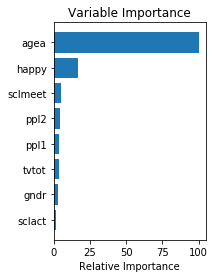

In [96]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

clf.fit(X_train, y_train)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

PCA didn't help at all, possibly because the people variables were of so little importance to the outcome. It looks like the reason it didn't work particularly well is because most of the variance for the three variables does not have any particular relationship with the outcome variable.

## Adding new features
__Hypothesis:__ Adding features that are tranformations of features already existing in the dataset will decrease performance. Typically the reason to create features that are one feature multiplied by another, or one feature raised to a power, is because the data scientist is using linear regression of some sort and the data indicates the presence of a polynomial relationship. However, we are using an implementation of boosted gradient which does not make the same assumptions of linearity. Therefore, adding features that are in fact transformations of existing features will most likely make the model more sensitive to overfitting thereby decreasing model performance.

In [97]:
cnt += 1

In [98]:
X = safe_drop(df, ['idno', 'cntry', 'year']).dropna()
y = X.partner - 1
X = safe_drop(X, 'partner')

p = pca(n_components=2)
p.fit(X.loc[:, X.columns[X.columns.str.contains('ppl')]])
ppl = p.transform(X.loc[:, X.columns[X.columns.str.contains('ppl')]])

In [99]:
X = pd.concat([safe_drop(X, ['ppltrst', 'pplhlp', 'pplfair']).reset_index(), 
           pd.DataFrame(ppl, columns=['ppl1', 'ppl2'])], axis=1).set_index('index')
X.index.name = None

In [100]:
# New feature of happy and ppl2
X['happy_ppl'] = X.happy * X.ppl2

# New feature, tvtot and sclmeet
X['tvtot_sclact'] = X.tvtot * X.sclact

# Sclact cubed
X['sclmeet_sq'] = X.sclmeet**2

In [101]:
# We'll make 250 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()
print('Elapsed time: {0} seconds'.format(end-start))

Elapsed time: 1.9429386899998917 seconds


In [102]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [103]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0
4,0.681110,0.116976,0.201915,1.934543,5.0
5,0.748251,0.059040,0.192709,1.624306,6.0
6,0.747146,0.058795,0.194059,1.503820,7.0
7,0.744446,0.059899,0.195655,1.942939,8.0


In [104]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.744
Type I error: 0.060
Type II error: 0.196
Time elapsed: 1.9 seconds


And I was right! Though it's slight, accuracy did decrease when transformed features were added on top of the original features.

### Feature importance

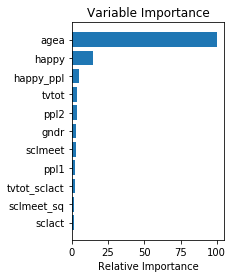

In [106]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

clf.fit(X_train, y_train)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [107]:
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0
4,0.681110,0.116976,0.201915,1.934543,5.0
5,0.748251,0.059040,0.192709,1.624306,6.0
6,0.747146,0.058795,0.194059,1.503820,7.0
7,0.744446,0.059899,0.195655,1.942939,8.0


# Model 9: Increasing Tree Depth
__Hypothesis:__ Increasing tree depth will lead to worse accuracy due to overfitting, and the relatively few variables that are actually important for predicting parter state.

In [108]:
cnt += 1

In [114]:
X = safe_drop(df, ['cntry', 'idno', 'year']).dropna()
y = X.partner - 1
X = safe_drop(X, 'partner')

In [115]:
# We'll make 250 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)

start = perf_counter()
predictions = cvp(clf, X, y, cv=3)
end = perf_counter()

In [116]:
summ = compute_acc(y, predictions)
summ['time'] = end-start
summ['model_no'] = cnt

In [117]:
try:
    result_summ.drop(result_summ.loc[result_summ.model_no==cnt].index, axis=0, inplace=True)
except Exception as e:
    print(e)

result_summ = result_summ.append(summ, ignore_index=True)
result_summ

,acc,type1,type2,time,model_no
0,0.685651,0.119676,0.194673,0.000055,1.0
1,0.682143,0.119828,0.198030,0.000087,2.0
2,0.679146,0.123236,0.197619,8.152791,3.0
3,0.686510,0.117712,0.195778,2.016423,4.0
4,0.681110,0.116976,0.201915,1.934543,5.0
5,0.748251,0.059040,0.192709,1.624306,6.0
6,0.747146,0.058795,0.194059,1.503820,7.0
7,0.744446,0.059899,0.195655,1.942939,8.0
8,0.734381,0.076470,0.189149,3.726293,9.0


In [118]:
print('Overall accuracy: {0:.3f}'.format(summ['acc']))
print('Type I error: {0:.3f}'.format(summ['type1']))
print('Type II error: {0:.3f}'.format(summ['type2']))
print('Time elapsed: {0:.1f} seconds'.format(summ['time']))

Overall accuracy: 0.734
Type I error: 0.076
Type II error: 0.189
Time elapsed: 3.7 seconds


And my hypothesis was correct. With all other hyperparameters the same as model 6--250 trees; dropped country, year, and id--increasing the depth of the trees decreased model performance.

# Comparing Accuracies

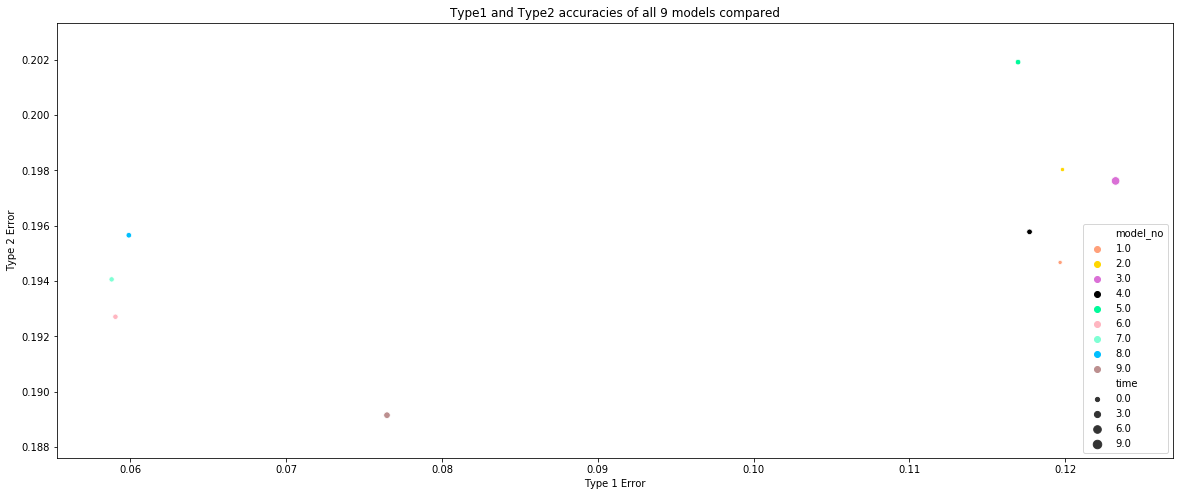

In [129]:
result_summ.loc[:, 'model_no'] = result_summ.model_no.astype('str')
f, ax = plt.subplots(figsize=(20, 8))
sns.scatterplot('type1', 'type2', data=result_summ, hue='model_no', size='time', 
                palette = ['lightsalmon', 'gold', 'orchid', 'black',
                           'mediumspringgreen', 'lightpink', 'aquamarine', 
                           'deepskyblue', 'rosybrown'],ax=ax)
plt.title('Type1 and Type2 accuracies of all 9 models compared')
plt.xlabel('Type 1 Error')
plt.ylabel('Type 2 Error')
plt.show()

I'll talk about Type 1 and Type 2 error below in more detail, but one interesting observation is that, in this case, the models that were less computationally intensive were also more accurate. This is most likely because computational time in gradient boosting is closely tied to the number of trees and more trees led to more overfitting for this particular dataset.

# Conclusion
- Feature selection can have a bigger impact on model performance than hyperparameter tuning;
- Adding transformations of features to account for polynommial relationships between the indicator and outcome variable does not help and in fact decreases performance in tree-based models because these models do not make the same assumptions about linearity. Additionally, gradient boosting is already prone to overfitting and highly correlated variables probably don't help with that; 
- Starting with very simple weak performers can still lead to decent results when using ensemble methods;
- Gradient boosting appears to be a less time-consuming method compared to SVM; and
- There is no best model. Something I missed the first time through this experiment is that increasing tree depth (model 9) lowered overall accuracy but increased sensitivity (false negatives). On the other hamd, combining correlated variables in addition to dropping less important features (model 9) led to the highest precision and the lowest Type I error.